Monte Carlo scatter correction uses SIMIND as a backend. See the website https://simind.blogg.lu.se/exempelsida/ for instructions on how to install, and how to cite their work. Once `simind` has been set as a path variable on your system (one of their install instructions), then you should be able to run the code of this tutorial.

In [1]:
import os
import sys
import torch
from pytomography.io.SPECT import simind
import itk
from torch.nn.functional import avg_pool3d
import numpy as np
from pytomography.projectors.SPECT import SPECTSystemMatrix
from pytomography.transforms.SPECT import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEM
from pytomography.likelihoods import PoissonLogLikelihood
from pytomography.utils import compute_EW_scatter
from pytomography.utils import simind_mc
import matplotlib.pyplot as plt
sys.path.append('./src')

In this tutorial we'll reconstruct the 113keV peak of SIMIND simulated Lu-177 data. The 113keV peak does not lend itself to TEW as well as the 208keV due to an increased number of scatter events and a non-linear variation of scatter across the photopeak window. As such, Monte Carlo scatter correction can lead to less systematic bias in the reconstruction.

In [2]:
# Change this to where you downloaded the tutorial data
PATH = '/disk1/pytomography_tutorial_data'
PATH = os.path.join(PATH, 'mc_tutorials')

Specify the file paths

In [13]:
files_NM = [os.path.join(PATH, 'lu177_SYME_jaszak_lowres', f'tot_w{i}.h00') for i in range(4,7)]

file_NM_scatter = os.path.join(PATH, 'lu177_SYME_jaszak_lowres', 'sca_w4.h00')
file_amap_113keV = os.path.join(PATH, 'lu177_SYME_jaszak_lowres', 'amap113.hct')
file_amap_140keV = os.path.join(PATH, 'lu177_SYME_jaszak_lowres', 'amap140.hct')
amap113 = simind.get_attenuation_map(file_amap_113keV)
amap140 = simind.get_attenuation_map(file_amap_140keV)
calib113 = 11.3 # CPS/MBq obtained from point source scan

Specify a given activity and time per projeciton:

In [4]:
activity = 1000 # MBq
time_per_proj = 15 # s

Now we'll create the system matrix in the typical way done in the introductory tutorials, and we'll also make it so that the projection data has 4.8mm instead of 2.4mm pixel size:

In [14]:
object_meta, proj_meta = simind.get_metadata(files_NM[0])
projections_noiseless = simind.get_projections(files_NM)  * activity * time_per_proj
scatter_noiseless = simind.get_projections(file_NM_scatter) * activity * time_per_proj
ww_peak = simind.get_energy_window_width(files_NM[0])
ww_lower = simind.get_energy_window_width(files_NM[1])
ww_upper = simind.get_energy_window_width(files_NM[2])
projections = torch.poisson(projections_noiseless)
scatter_TEW = compute_EW_scatter(projections[1], projections[2], ww_lower, ww_upper, ww_peak)

att_transform = SPECTAttenuationTransform(amap113)
psf_meta = simind.get_psfmeta_from_header(files_NM[0])
psf_transform = SPECTPSFTransform(psf_meta)
system_matrix = SPECTSystemMatrix(
    obj2obj_transforms = [att_transform,psf_transform],
    proj2proj_transforms = [],
    object_meta = object_meta,
    proj_meta = proj_meta
    )

We'll reconstruct using the true scatter from SIMIND; this is not possible in practice since we don't know the true scatter

In [15]:
likelihood = PoissonLogLikelihood(system_matrix, projections[0], scatter_noiseless)
recon_algorithm = OSEM(likelihood)
recon_truescatter = recon_algorithm(n_iters=6, n_subsets=8)

Now we'll reconstruct using the triple energy window technique. We'll demonstrate that this is worse than Monte Carlo scatter correction

In [7]:
likelihood = PoissonLogLikelihood(system_matrix, projections[0], scatter_TEW)
recon_algorithm = OSEM(likelihood)
recon_TEW = recon_algorithm(n_iters=6, n_subsets=8)

The code below is as follows:
1. Get the scan parameters from the object and projection metadata
2. Add information that isn't stored in the metadata, such as the isotope name, the collimator type, the cover thickness (assumed to be Aluminum for now), the equivalent backscatter thickness representing the photomultipliers (assumed to be pyrex equivalent), the scintillator crystal thickness (assumed to be NaI) and the energy resolution of the system at 140keV (assumed to proportional to $E^{-1/2}$ at other energies).

In [8]:
index_dict = simind_mc.get_simind_params_from_metadata(object_meta, proj_meta)
index_dict.update(simind_mc.get_simind_isotope_detector_params(
    isotope_name = 'lu177',
    collimator_type= 'sy-me',
    cover_thickness=0.1, # cm. assumes aluminum
    backscatter_thickness=6.6, # cm, assumes pyrex equivalent
    crystal_thickness=0.9525, # cm, assumes NaI
    energy_resolution_140keV=9.9, # %
    #advanced_collimator_modeling=True,
    #random_collimator_movement=True
))
energy_window_params = simind_mc.get_energy_window_params_simind(files_NM)
primary_window_idxs = [0]
NMIL_EVENTS = 5.

Now we set the number of parallel CPU cores to run the scatter simulation. If your system has less cores, you may need to change this value:

In [9]:
N_PARALLEL = 20 

Now we set up the reconstruction. For this, we set up a `MonteCarloScatterCallback` that we use within the reconstruction algorithm to update the `additive_term` of the `likelihood`, which is initially not given (e.g. set to zero).

* The initial object given to the callback is the reconstruction with no scatter used. 
* The callback is called after every iteration, and every two subsets. These numbers can be adjusted so that the current scatter estimate is updated more/less often.
* There are post smoothing values that can be experimented with to possibly require less scatter events to be generated

The callback is used within the reconstruction algorithm and fed as a `callback` argument.

**Note: With 20 cores, this reconstruction takes about 40 minutes**

In [10]:
likelihood = PoissonLogLikelihood(system_matrix, projections[0])
MC_callback = simind_mc.MonteCarloScatterCallback(
        likelihood = likelihood,
        object_initial = recon_TEW,
        simind_index_dict = index_dict,
        attenuation_map_140keV = amap140,
        calibration_factor = calib113,
        energy_window_params = energy_window_params,
        primary_window_idxs = primary_window_idxs,
        n_events = NMIL_EVENTS * 1e6,
        n_parallel = 20, # adjust for less/more CPU cores
        run_every_iter = 1,
        run_every_subsets = 2,
        #post_smoothing_sigma_r = 0.36, # cm
        #post_smoothing_sigma_z = 0.36, # cm
        )
recon_algorithm = OSEM(likelihood)
recon_mc = recon_algorithm(n_iters=6, n_subsets=8, callback=MC_callback)

Let's compare the three reconstructions with different scatter methods:

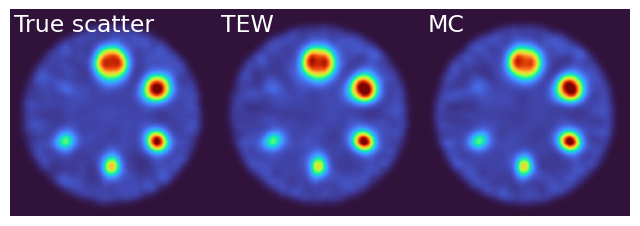

In [16]:
xlims = [40,128-40]
ylims = [40,128-40]
labels = ['True scatter', 'TEW', 'MC']
fig, ax = plt.subplots(1, 3, figsize=(8,3), gridspec_kw={'wspace': 0.0})
for i, recon in enumerate([recon_truescatter, recon_TEW, recon_mc]):
    ax[i].imshow(recon[:,:,64].cpu().numpy().T, cmap='turbo', vmax=40, interpolation='gaussian')
    ax[i].axis('off')
    ax[i].set_xlim(xlims)
    ax[i].set_ylim(ylims)
    ax[i].text(0.02, 0.98, labels[i], horizontalalignment='left', verticalalignment='top', transform=ax[i].transAxes, fontsize=17, color='white')

In [17]:
sphere_masks_all = np.transpose(itk.GetArrayFromImage(itk.imread(os.path.join(PATH, 'sphere_masks_highres.seg.nrrd'))), (1,2,0))
masks = []
for i in range(1,8):
    mask = torch.tensor((sphere_masks_all==i)).to(torch.float32)
    # Reduce size because we reduced projection size
    mask = avg_pool3d(mask.unsqueeze(0).unsqueeze(0), 4).squeeze()
    masks.append(mask)

IDX = 5
print(f'True scatter total counts: {(recon_truescatter.cpu()*masks[IDX]).sum()}')
print(f'TEW scatter total counts: {(recon_TEW.cpu()*masks[IDX]).sum()}')
print(f'MC scatter total counts: {(recon_mc.cpu()*masks[IDX]).sum()}')

True scatter total counts: 5542.7119140625
TEW scatter total counts: 5909.03857421875
MC scatter total counts: 5578.419921875
